In [5]:
from __future__ import print_function 
experiment_setup_name = "tutorial.gym.atari.spaceinvaders-v0.cnn"


#gym game title
GAME_TITLE = 'SpaceInvaders-v0'

#how many parallel game instances can your machine tolerate
N_PARALLEL_GAMES = 5

#how long is one replay session from a batch
#since we have window-like memory (no recurrent layers), we can use relatively small session weights
replay_seq_len = 10


#theano device selection. GPU is, as always, in preference, but not required
%env THEANO_FLAGS='device=cpu'



env: THEANO_FLAGS='device=cpu'


__For short version, see [repository](https://github.com/yandexdataschool/dqn_binder) or [insta-launcher](http://mybinder.org:/repo/yandexdataschool/dqn_binder)__

# This tutorial is a showcase on how to use AgentNet for OpenAI Gym environments


* Space Invaders game as an example
* Training a simple lasagne neural network for Q_learning objective
 * This example can be easily modified to use convolutional networks and/or recurrent agent memory. 
 
* Training via simple experience replay (explained below)
* Only using utility recurrent layers for simplicity of this example
 * but adding a few RNNs or GRUs shouldn's be a problem
* the network is trained with a simple one-step Q-learning for simplicity


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym
  
### Installing it
 * If nothing changed on their side, to run this, you bacically need to follow their install instructions - 
 
```
git clone https://github.com/openai/gym.git
cd gym
pip install -e .[all]
```

## New to AgentNet and Lasagne?
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb


# Experiment setup
* Here we basically just load the game

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

[2016-10-27 13:21:05,495] Making new env: SpaceInvaders-v0


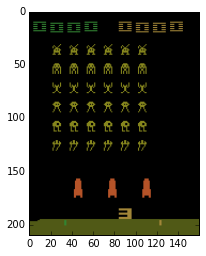

In [7]:
import gym
atari = gym.make(GAME_TITLE)
atari.reset()
plt.imshow(atari.render('rgb_array'))

### Game Parameters
* observation dimensions, actions, etc

In [8]:
n_actions = atari.action_space.n
observation_shape = (None,)+atari.observation_space.shape
action_names = atari.get_action_meanings()
print(action_names)

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [9]:
del atari

# agent setup step by step
* An agent implementation may contain these parts:
 * Observation(s)
   * InputLayers where observed game states (here - images) are sent at each tick 
 * Memory layer(s)
   * A dictionary that maps "New memory layers" to "prev memory layers"
 * Policy layer (e.g. Q-values or probabilities)
   * in this case, a lasagne dense layer based on observation layer
 * Resolver - acton picker layer
   * chooses what action to take given Q-values
   * in this case, the resolver has epsilon-greedy policy
   
   
We are going to build something of this shape:

(one can assume that the 'time' goes from left to right, inputs are at the bottom and outputs go to the top)



![window_dqn_scheme](http://s32.postimg.org/yy5q3wadx/window_dqn.png)
  




##### Agent observations

* Here you define where observations (game images) appear in the network

In [10]:
import lasagne
from lasagne.layers import InputLayer, DimshuffleLayer

In [11]:
#image observation at current tick goes here
observation_layer = InputLayer(observation_shape,
                               name="images input")


#reshape to [batch, color, x, y] to allow for convolutional layers to work correctly
observation_reshape = DimshuffleLayer(observation_layer,(0,3,1,2))

observation_reshape = lasagne.layers.Pool2DLayer(observation_reshape,(2,2),mode='average_inc_pad')



  
### Agent memory states
 * Here you can define arbitrary transitions between "previous state" variables and their next states
 * The rules are
   * previous states must be input layers
   * next states must have same shape as previous ones
   * otherwise it can be any lasagne network
   * AgentNet.memory has several useful layers
   
 * During training and evaluation, your states will be updated recurrently
   * next state at t=1 is given as previous state to t=2
 
 * Finally, you have to define a dictionary mapping new state -> previous state


### In this demo
Since we have almost fully observable environment AND we want to keep baseline simple, we shall use no recurrent units.
However, Atari game environments are known to have __flickering__ effect where some sprites are shown only on odd frames and others on even ones - that was used to optimize performance at the time.
To compensate for this, we shall use the memory layer called __WindowAugmentation__ which basically maintains a K previous time steps of what it is fed with.

One can try to use
 * GRU - `from agentnet.memory import GRUMemoryLayer`
 * RNN - `from agentnet.memory import RNNCell`
 * any custom lasagne layers that compute new memory states


In [12]:

#memory
#using simple window-based memory that stores several states
#the SpaceInvaders environment does not need any more as it is almost fully-observed
from agentnet.memory import WindowAugmentation


window_size = 3


#prev state input
prev_window = InputLayer((None,window_size)+tuple(observation_reshape.output_shape[1:]),
                        name = "previous window state")


#our window
window = WindowAugmentation(observation_reshape,
                            prev_window,
                            name = "new window state")



memory_dict = {window:prev_window}



##### Neural network body
Our strategy, again:
 * take pixel-wise maximum over the window
 * apply some layers
 * use output layer to predict Q-values(see next)

In [13]:
from lasagne.layers import DropoutLayer,DenseLayer, ExpressionLayer
#you may use any other lasagne layers, including convolutions, batch_norms, maxout, etc

#pixel-wise maximum over the temporal window (to avoid flickering)
window_max = ExpressionLayer(window,
                             lambda a: a.max(axis=1),
                             output_shape = (None,)+window.output_shape[2:])



#a simple lasagne network (try replacing with any other lasagne network and see what works best)    
nn = lasagne.layers.Conv2DLayer(window_max,32,filter_size=8,stride=(4,4), name='cnn0')
nn = lasagne.layers.Conv2DLayer(nn,64,filter_size=8,stride=(4,4), name='cnn1')

#nn = DropoutLayer(nn,name = "dropout", p=0.05) #will get deterministic during evaluation
nn = DenseLayer(nn,num_units=256,name='dense1')


#WARNING! if your network is computing too slowly, try decreasing the amount of neurons


##### Agent policy and action picking
* Since we are training a deep Q-network, we need it to predict Q-values and take actions.
* Hence we define a lasagne layer that is used for action output

* To pick actions, we use an epsilon-greedy resolver
  * Note that resolver outputs particular action IDs and not probabilities.
  * These actions are than sent into the environment

In [14]:
#q_eval
q_eval = DenseLayer(nn,
                   num_units = n_actions,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="QEvaluator")

#resolver
from agentnet.resolver import EpsilonGreedyResolver
resolver = EpsilonGreedyResolver(q_eval,name="resolver")



##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [15]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layer,
              memory_dict,
              q_eval,resolver)


In [16]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[cnn0.W,
 cnn0.b,
 cnn1.W,
 cnn1.b,
 dense1.W,
 dense1.b,
 QEvaluator.W,
 QEvaluator.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* We define a small container that stores
 * game emulators
 * last agent observations
 * agent memories at last time tick
* This allows us to instantly continue a session from where it stopped



* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf


__The EnvPool class already contains experience replay and update functionality, but to be more explicit, we re-write them here.__ 

__If you want shorter version, see the url at the top of the notebook.__

In [17]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,GAME_TITLE, N_PARALLEL_GAMES)


[2016-10-27 13:21:19,892] Making new env: SpaceInvaders-v0
[2016-10-27 13:21:19,971] Making new env: SpaceInvaders-v0
[2016-10-27 13:21:20,046] Making new env: SpaceInvaders-v0
[2016-10-27 13:21:20,124] Making new env: SpaceInvaders-v0
[2016-10-27 13:21:20,208] Making new env: SpaceInvaders-v0


In [18]:
%%time
observation_log,action_log,reward_log,_,_,_  = pool.interact(50)

print(np.array(action_names)[np.array(action_log)[:3,:5]])

[['LEFT' 'LEFT' 'LEFT' 'LEFT' 'LEFT']
 ['LEFT' 'LEFT' 'LEFT' 'LEFT' 'LEFT']
 ['LEFT' 'LEFT' 'LEFT' 'LEFT' 'LEFT']]
CPU times: user 2.6 s, sys: 1.96 s, total: 4.55 s
Wall time: 2.72 s


# experience replay pool

Since our network exists in a theano graph and OpenAI gym doesn't, we shall train out network via experience replay.

To do that in AgentNet, one can use a SessionPoolEnvironment.

It's simple: you record new sessions using `interact(...)`, and than immediately train on them.

1. Interact with Atari, get play sessions
2. Store them into session environment
3. Train on them
4. Repeat


In [19]:
#Create an environment with all default parameters
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=agent.agent_states)

In [20]:
def update_pool(env, pool,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    preceding_memory_states = list(pool.prev_memory_states)
    
    #get interaction sessions
    observation_tensor,action_tensor,reward_tensor,_,is_alive_tensor,_= pool.interact(n_steps=n_steps)
        
    #load them into experience replay environment
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,preceding_memory_states)
    
    

In [21]:
#load first  sessions
update_pool(env,pool,replay_seq_len)

A more sophisticated way of training is to store a large pool of sessions and train on random batches of them. 
* Why that is expected to be better - http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html
* Or less proprietary - https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

To do that, one might make use of
* ```env.load_sessions(...)``` - load new sessions
* ```env.get_session_updates(...)``` - does the same thing via theano updates (advanced)
* ```batch_env = env.sample_session_batch(batch_size, ...)``` - create an experience replay environment that contains batch_size random sessions from env (rerolled each time). Should be used in training instead of env.
* ```env.select_session_batch(indices)``` does the same thing deterministically.


# Interacting with environment
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

### Training via experience replay

* We use agent we have created to replay environment interactions inside Theano
* to than train on the replayed sessions via theano gradient propagation
* this is essentially basic Lasagne code after the following cell

In [22]:
#get agent's Qvalues obtained via experience replay
_,_,_,_,qvalues_seq = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
    optimize_experience_replay=True,
)


#The "_"s are
#first - environment states - which is empty since we are using session pool as our environment
#second - observation sequences - whatever agent recieved at observation input(s) on each tick
#third - a dictionary of all agent memory units (RNN, GRU, NTM) - empty as we use none of them
#last - "imagined" actions - actions agent would pick now if he was in that situation 
#                              - irrelevant since we are replaying and not actually playing the game now


# Evaluating loss function
* In this part we are using some basic Reinforcement Learning methods (here - Q-learning) to train
* AgentNet has plenty of such methods, but we shall use the simple Q_learning for now.
* Later you can try:
 * SARSA - simpler on-policy algorithms
 * N-step q-learning (requires n_steps parameter)
 * Advantage Actor-Critic (requires state values and probabilities instead of Q-values)


* The basic interface is .get_elementwise_objective 
  * it returns loss function (here - squared error against reference Q-values) values at each batch and tick
  
* If you want to do it the hard way instead, try .get_reference_Qvalues and compute errors on ya own
  

In [23]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later




#IMPORTANT!
# If you are training on a game that has rewards far outside some [-5,+5]
# it is a good idea to downscale them to avoid divergence
scaled_reward_seq = env.rewards
#For SpaceInvaders, however, not scaling rewards is at least working


elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                        env.actions[0],
                                                        scaled_reward_seq,
                                                        env.is_alive,
                                                        gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
mse_loss = elwise_mse_loss.sum() / env.is_alive.sum()

In [24]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-5

In [25]:
loss = mse_loss + reg_l2

In [26]:
# Compute weight updates
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

In [27]:
#mean session reward
mean_session_reward = env.rewards.sum(axis=1).mean()

# Compile train and evaluation functions

In [28]:
import theano
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)
evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
[2016-10-27 13:22:20,879] We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


# Session visualization tools

Just a helper function that draws current game images.

In [31]:
def display_sessions(max_n_sessions = 3):
    """just draw random images"""
    
    plt.figure(figsize=[15,8])
    
    pictures = [atari.render("rgb_array") for atari in pool.envs[:max_n_sessions]]
    for i,pic in enumerate(pictures):
        plt.subplot(1,max_n_sessions,i+1)
        plt.imshow(pic)
    plt.show()
    

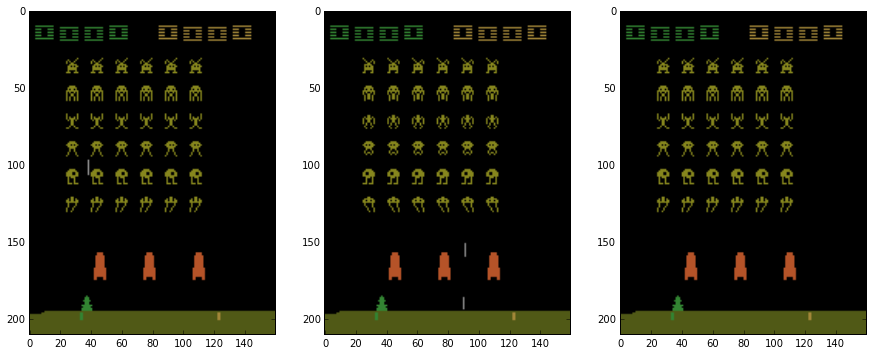

In [32]:
#visualize untrained network performance (which is mostly random)
display_sessions()

# Training loop

In [33]:
import os

In [34]:
from agentnet.display import Metrics
score_log = Metrics()

In [35]:
#starting epoch
epoch_counter = 1
#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

In [36]:
%%time

n_epochs = 25000
#25k may take hours to train.
#consider interrupt early.



for i in range(n_epochs):    
    
    
    #train
    update_pool(env,pool,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%5 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        update_pool(env,pool,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,pool,replay_seq_len)

        print("epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy))
        print("rec %.3f reg %.3f"%(q_loss,l2_penalty))

    if epoch_counter %500 ==0:
        print("Learning curves:")
        score_log.plot()


        print("Random session examples")
        display_sessions()
    

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

epoch 5,loss 27.29023, epsilon 0.49776, rewards: ( e-greedy 0.00000, greedy 0.00000) 
rec 27.286 reg 0.005
epoch 10,loss 28.11220, epsilon 0.49552, rewards: ( e-greedy 0.80000, greedy 0.00000) 
rec 28.108 reg 0.005
epoch 15,loss 47.72080, epsilon 0.49330, rewards: ( e-greedy 2.02000, greedy 0.00000) 
rec 47.716 reg 0.005
epoch 20,loss 3.10443, epsilon 0.49109, rewards: ( e-greedy 1.81800, greedy 0.00000) 
rec 3.100 reg 0.005
epoch 25,loss 8.39886, epsilon 0.48889, rewards: ( e-greedy 1.63620, greedy 0.00000) 
rec 8.394 reg 0.005
epoch 30,loss 10.25280, epsilon 0.48670, rewards: ( e-greedy 1.47258, greedy 0.00000) 
rec 10.248 reg 0.005
epoch 35,loss 8.06316, epsilon 0.48452, rewards: ( e-greedy 1.52532, greedy 0.10000) 
rec 8.059 reg 0.005
epoch 40,loss 3.51100, epsilon 0.48236, rewards: ( e-greedy 1.37279, greedy 0.09000) 
rec 3.506 reg 0.005
epoch 45,loss 809.23847, epsilon 0.48020, rewards: ( e-greedy 5.23551, greedy 0.08100) 
rec 809.234 reg 0.005
epoch 50,loss 16.81925, epsilon 0.4

KeyboardInterrupt: 

# Evaluating results
 * Here we plot learning curves and sample testimonials

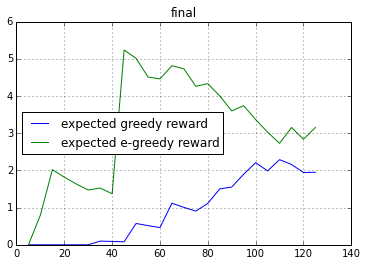

In [37]:
score_log.plot("final")

Random session examples


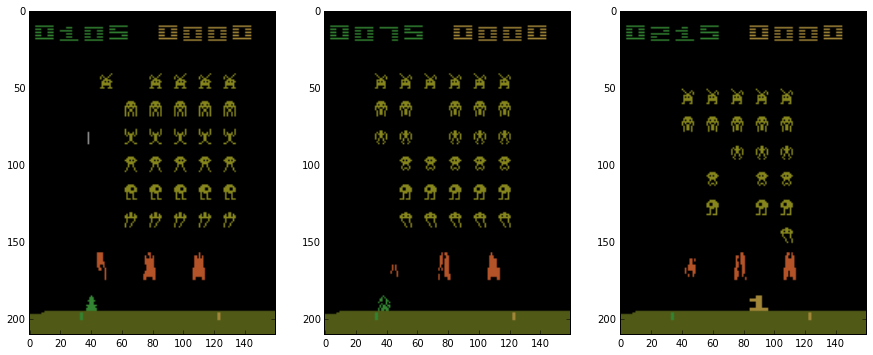

In [38]:
print("Random session examples")
display_sessions()


# Submission
Here we simply run the OpenAI gym submission code and view scores

In [39]:
resolver.epsilon.set_value(0)

In [40]:
[m.close() for m in gym.monitoring._open_monitors()]

[]

In [48]:
[mem.output_shape for mem in agent.agent_states]

[(None, 3, 3, 105, 80)]

In [52]:

save_path = '/tmp/AgentNet-simplenet-SpaceInvadersv0-Recording0'


step = agent.get_react_function()

subm_env = gym.make(GAME_TITLE)

#starting monitor. This setup does not write videos
#subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
subm_env.monitor.start(save_path,force=True)


for i_episode in xrange(10):
    
    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = [np.zeros((1,) + tuple(mem.output_shape[1:]),
                              dtype=getattr(mem,"output_dtype",theano.config.floatX))
                             for mem in agent.agent_states]
    
    
    t = 0
    while True:

        agent_output = step([observation],*prev_memories)
        action,new_memories = agent_output[0],agent_output[1:]
        
        observation, reward, done, info = subm_env.step(action[0])
        
        prev_memories = new_memories
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
        t+=1

subm_env.monitor.close()

[2016-10-27 13:35:12,390] Making new env: SpaceInvaders-v0
[2016-10-27 13:35:12,458] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-10-27 13:35:12,545] Starting new video recorder writing to /tmp/AgentNet-simplenet-SpaceInvadersv0-Recording0/openaigym.video.6.10494.video000000.mp4
[2016-10-27 13:35:26,772] Starting new video recorder writing to /tmp/AgentNet-simplenet-SpaceInvadersv0-Recording0/openaigym.video.6.10494.video000001.mp4


Episode finished after 801 timesteps
Episode finished after 825 timesteps


KeyboardInterrupt: 

In [ ]:

gym.upload(save_path,
           
           #this notebook
           writeup=<url to my gist>, 
           
           #your api key
           api_key=<my_own_api_key>)


# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for examples? Try examples/Deep Kung Fu for most of these features


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__